In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib tqdm pycocotools

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))  # Optional: See GPU name

True
NVIDIA GeForce RTX 4070 Laptop GPU


In [3]:
# ✅ FULL Image Captioning Setup + Model + Training (Jupyter GPU)

# -----------------------------
# STEP 1: Download + Extract COCO (Already Included)
# -----------------------------
import os
import zipfile
import requests
from tqdm import tqdm
import shutil

# Download helpers
def download_file(url, filename):
    if os.path.exists(filename):
        print(f"✅ Already downloaded: {filename}")
        return
    response = requests.get(url, stream=True)
    total = int(response.headers.get('content-length', 0))
    with open(filename, 'wb') as file, tqdm(
        desc=filename,
        total=total,
        unit='B', unit_scale=True, unit_divisor=1024
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)

def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Extracted to: {extract_to}")

# Prepare folders and fetch
os.makedirs("COCO/images", exist_ok=True)
os.makedirs("COCO/annotations", exist_ok=True)
download_file("http://images.cocodataset.org/zips/train2017.zip", "train2017.zip")
unzip_file("train2017.zip", "COCO/images")
download_file("http://images.cocodataset.org/annotations/annotations_trainval2017.zip", "annotations_trainval2017.zip")
unzip_file("annotations_trainval2017.zip", ".")
shutil.move("annotations/captions_train2017.json", "COCO/annotations/captions_train2017.json")

✅ Already downloaded: train2017.zip
✅ Extracted to: COCO/images
✅ Already downloaded: annotations_trainval2017.zip
✅ Extracted to: .


'COCO/annotations/captions_train2017.json'

In [4]:
# -----------------------------
# STEP 2: Dataset + Vocabulary
# -----------------------------
from torchvision import transforms
from torchvision.datasets import CocoCaptions
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

image_path = 'COCO/images/train2017'
annotation_path = 'COCO/annotations/captions_train2017.json'
caption_dataset = CocoCaptions(root=image_path, annFile=annotation_path, transform=transform)
train_size = int(0.9 * len(caption_dataset))
val_size = len(caption_dataset) - train_size
train_set, val_set = random_split(caption_dataset, [train_size, val_size])

# Vocabulary
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()} 

    def __len__(self):
        return len(self.itos)

    def tokenizer(self, text):
        return text.lower().translate(str.maketrans('', '', '.,!?')).split()

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in self.tokenizer(text)]

    def decode(self, token_ids):
        words = []
        for idx in token_ids:
            word = self.itos.get(idx, "<UNK>")
            if word in ("<START>", "<END>", "<PAD>"):
                continue
            words.append(word)
        return " ".join(words)

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, vocab):
        self.dataset = dataset
        self.vocab = vocab

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, captions = self.dataset[idx]
        tokens = [self.vocab.stoi["<START>"]] + self.vocab.numericalize(captions[0]) + [self.vocab.stoi["<END>"]]
        return img, torch.tensor(tokens)

class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        captions = [item[1] for item in batch]
        imgs = torch.cat(imgs, dim=0)
        captions = pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)
        return imgs, captions

loading annotations into memory...
Done (t=2.44s)
creating index...
index created!


In [30]:
# Build and save new vocab
vocab = Vocabulary(freq_threshold=1)
all_captions = []
for i in tqdm(range(train_size), desc="Building Vocab"):
    _, caps = caption_dataset[i]
    all_captions.extend(caps)
vocab.build_vocab(all_captions)

# Save it to disk
import pickle
with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)
print("✅ Saved new vocab with decode() method.")

Building Vocab: 100%|██████████████████████████████████████████████████████████| 106458/106458 [34:07<00:00, 51.98it/s]


✅ Saved new vocab with decode() method.


In [5]:
import pickle

with open("vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

print("✅ Loaded vocab from vocab.pkl")

✅ Loaded vocab from vocab.pkl


In [6]:
train_loader = DataLoader(CocoDataset(train_set, vocab), batch_size=32, shuffle=True, collate_fn=MyCollate(vocab.stoi["<PAD>"]))
val_loader = DataLoader(CocoDataset(val_set, vocab), batch_size=32, shuffle=False, collate_fn=MyCollate(vocab.stoi["<PAD>"]))

In [7]:
# -----------------------------
# STEP 3: Model: CNN + Transformer Decoder
# -----------------------------
import torch.nn as nn
import torchvision.models as models
import math

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad = False
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])  # Keep up to conv5_x
        self.conv = nn.Conv2d(2048, embed_size, kernel_size=1)  # Compress channels

    def forward(self, images):
        features = self.resnet(images)             # [B, 2048, H, W]
        features = self.conv(features)             # [B, embed_size, H, W]
        B, C, H, W = features.shape
        features = features.view(B, C, H * W)      # [B, C, H*W]
        features = features.permute(2, 0, 1)       # [seq_len, B, embed_size]
        return features


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerCaptioner(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads, num_layers, dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size)
        decoder_layer = nn.TransformerDecoderLayer(embed_size, num_heads, 512, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.embed_size = embed_size

    def forward(self, tgt, memory, tgt_mask=None):
        tgt_emb = self.embed(tgt) * math.sqrt(self.embed_size)
        tgt_emb = self.pos_encoder(tgt_emb)
        output = self.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask)
        return self.fc_out(output)

    def generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [35]:
# -----------------------------
# STEP 4: Training Loop (Stable - No AMP)
# -----------------------------
from torch import optim

# Set reproducibility
import random
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = EncoderCNN(embed_size=256).to(device)
decoder = TransformerCaptioner(
    embed_size=256, vocab_size=len(vocab), num_heads=4, num_layers=2
).to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
optimizer = optim.Adam(
    list(encoder.conv.parameters()) + list(decoder.parameters()), lr=3e-4
)

num_epochs = 20  # You can increase to 20 once this works well
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0

    for imgs, captions in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, captions = imgs.to(device), captions.to(device)

        tgt_input = captions[:, :-1].transpose(0, 1)
        tgt_output = captions[:, 1:].transpose(0, 1)
        tgt_mask = decoder.generate_square_subsequent_mask(tgt_input.size(0)).to(device)

        optimizer.zero_grad()
        memory = encoder(imgs)
        outputs = decoder(tgt_input, memory, tgt_mask)
        loss = criterion(outputs.reshape(-1, outputs.size(-1)), tgt_output.reshape(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"✅ Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/20: 100%|██████████████████████████████████████████████████████████████████| 3327/3327 [43:16<00:00,  1.28it/s]


✅ Epoch 1, Loss: 3.4646


Epoch 2/20: 100%|██████████████████████████████████████████████████████████████████| 3327/3327 [40:46<00:00,  1.36it/s]


✅ Epoch 2, Loss: 2.8461


Epoch 3/20: 100%|██████████████████████████████████████████████████████████████████| 3327/3327 [41:58<00:00,  1.32it/s]


✅ Epoch 3, Loss: 2.6871


Epoch 4/20: 100%|██████████████████████████████████████████████████████████████████| 3327/3327 [42:35<00:00,  1.30it/s]


✅ Epoch 4, Loss: 2.5908


Epoch 5/20: 100%|██████████████████████████████████████████████████████████████████| 3327/3327 [40:53<00:00,  1.36it/s]


✅ Epoch 5, Loss: 2.5207


Epoch 6/20: 100%|██████████████████████████████████████████████████████████████████| 3327/3327 [42:26<00:00,  1.31it/s]


✅ Epoch 6, Loss: 2.4651


Epoch 7/20: 100%|██████████████████████████████████████████████████████████████████| 3327/3327 [41:03<00:00,  1.35it/s]


✅ Epoch 7, Loss: 2.4206


Epoch 8/20: 100%|██████████████████████████████████████████████████████████████████| 3327/3327 [40:45<00:00,  1.36it/s]


✅ Epoch 8, Loss: 2.3835


Epoch 9/20: 100%|██████████████████████████████████████████████████████████████████| 3327/3327 [41:33<00:00,  1.33it/s]


✅ Epoch 9, Loss: 2.3502


Epoch 10/20: 100%|█████████████████████████████████████████████████████████████████| 3327/3327 [41:01<00:00,  1.35it/s]


✅ Epoch 10, Loss: 2.3234


Epoch 11/20: 100%|███████████████████████████████████████████████████████████████| 3327/3327 [1:13:30<00:00,  1.33s/it]


✅ Epoch 11, Loss: 2.3004


Epoch 12/20: 100%|█████████████████████████████████████████████████████████████████| 3327/3327 [41:04<00:00,  1.35it/s]


✅ Epoch 12, Loss: 2.2783


Epoch 13/20: 100%|█████████████████████████████████████████████████████████████████| 3327/3327 [41:13<00:00,  1.34it/s]


✅ Epoch 13, Loss: 2.2580


Epoch 14/20: 100%|█████████████████████████████████████████████████████████████████| 3327/3327 [41:14<00:00,  1.34it/s]


✅ Epoch 14, Loss: 2.2400


Epoch 15/20: 100%|█████████████████████████████████████████████████████████████████| 3327/3327 [41:32<00:00,  1.33it/s]


✅ Epoch 15, Loss: 2.2239


Epoch 16/20: 100%|█████████████████████████████████████████████████████████████████| 3327/3327 [41:35<00:00,  1.33it/s]


✅ Epoch 16, Loss: 2.2091


Epoch 17/20: 100%|█████████████████████████████████████████████████████████████████| 3327/3327 [41:26<00:00,  1.34it/s]


✅ Epoch 17, Loss: 2.1951


Epoch 18/20: 100%|█████████████████████████████████████████████████████████████████| 3327/3327 [41:23<00:00,  1.34it/s]


✅ Epoch 18, Loss: 2.1815


Epoch 19/20: 100%|█████████████████████████████████████████████████████████████████| 3327/3327 [41:23<00:00,  1.34it/s]


✅ Epoch 19, Loss: 2.1685


Epoch 20/20: 100%|█████████████████████████████████████████████████████████████████| 3327/3327 [41:22<00:00,  1.34it/s]

✅ Epoch 20, Loss: 2.1580


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = EncoderCNN(embed_size=256).to(device)
decoder = TransformerCaptioner(embed_size=256, vocab_size=len(vocab), num_heads=4, num_layers=2).to(device)

checkpoint = torch.load('caption_model_20epochs.pth', map_location=device)
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

encoder.eval()
decoder.eval()

TransformerCaptioner(
  (embed): Embedding(30153, 256)
  (pos_encoder): PositionalEncoding()
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0

In [10]:
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
}, 'caption_model_20epochs.pth')

with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

print("✅ Model and vocab saved")

✅ Model and vocab saved


In [11]:
!pip install nltk

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sdigh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [47]:
def generate_caption_beam_search(decoder, encoder, image, vocab, beam_size=3, max_len=50):
    decoder.eval()
    encoder.eval()
    with torch.no_grad():
        memory = encoder(image.unsqueeze(0).to(device))  # Shape: [B, C, H, W]

        if memory.dim() == 4:
            B, C, H, W = memory.shape
            memory = memory.view(B, C, H * W).permute(2, 0, 1)  # → [seq_len, B, embed_dim]
        elif memory.dim() == 2:
            memory = memory.unsqueeze(1)

        sequences = [[[], 0.0, torch.tensor([[vocab.stoi["<START>"]]], device=device)]]

        for _ in range(max_len):
            all_candidates = []
            for seq, score, input_token in sequences:
                tgt_mask = decoder.generate_square_subsequent_mask(input_token.size(0)).to(device)
                output = decoder(input_token, memory, tgt_mask)
                log_probs = torch.nn.functional.log_softmax(output[-1, 0], dim=0)
                topk = torch.topk(log_probs, beam_size)

                for i in range(beam_size):
                    token_id = topk.indices[i].item()
                    token_log_prob = topk.values[i].item()

                    new_seq = seq + [token_id]
                    new_score = score + token_log_prob
                    new_input_token = torch.cat([input_token, torch.tensor([[token_id]], device=device)], dim=0)

                    all_candidates.append((new_seq, new_score, new_input_token))

            sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_size]

        final_seq = sequences[0][0]
        if vocab.stoi["<END>"] in final_seq:
            final_seq = final_seq[:final_seq.index(vocab.stoi["<END>"])]

        return vocab.decode(final_seq)

In [48]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_bleu(index, val_set, encoder, decoder, vocab, beam_width=5):
    encoder.eval()
    decoder.eval()

    image_tensor, references = val_set[index]
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # 🔁 Generate prediction using beam search
    pred_caption = generate_caption_beam_search(decoder, encoder, image_tensor.squeeze(0), vocab, beam_size=beam_width)

    # 🧾 Decode
    predicted_caption = pred_caption.split()
    references = [vocab.tokenizer(c) for c in references]
    
    # 📏 BLEU score
    smoothing = SmoothingFunction().method4
    bleu = sentence_bleu(references, predicted_caption, smoothing_function=smoothing)
    print("\n📝 Predicted:", " ".join(predicted_caption))
    print(f"📌 BLEU Score: {bleu:.4f}")

    # 🖼️ Show image
    image_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    image_np = image_np.clip(0, 1)
    plt.imshow(image_np)
    plt.title("Generated Caption")
    plt.axis("off")
    plt.show()



📝 Predicted: a white toilet sitting next to a bathroom sink
📌 BLEU Score: 0.7189


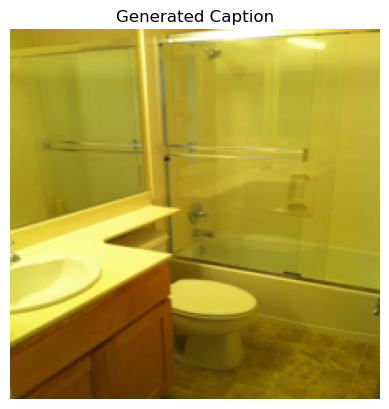

In [49]:
evaluate_bleu(index=1, val_set=val_set, encoder=encoder, decoder=decoder, vocab=vocab, beam_width=5)

In [41]:
# -----------------------------
# RESUME TRAINING: Epoch 21–50 with AMP, Gradient Clipping, and Loss Tracking
# -----------------------------
from torch import nn, optim
from torch.cuda.amp import GradScaler, autocast
import pickle, os
from tqdm import tqdm

# AMP Scaler and device
scaler = GradScaler()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load loss history if available
loss_history = []
if os.path.exists("loss_history_so_far.pkl"):
    with open("loss_history_so_far.pkl", "rb") as f:
        loss_history = pickle.load(f)
    print(f"📂 Loaded previous loss history with {len(loss_history)} epochs.")
else:
    print("⚠️ No previous loss history found, starting fresh.")

# Resume from wherever we left off
start_epoch = 20 + len(loss_history)
num_epochs = 50

if start_epoch >= num_epochs:
    print("✅ All epochs already completed.")
else:
    print(f"🚀 Resuming training from epoch {start_epoch+1} to {num_epochs}...")

    # Initialize models
    encoder = EncoderCNN(embed_size=256).to(device)
    decoder = TransformerCaptioner(embed_size=256, vocab_size=len(vocab), num_heads=4, num_layers=2).to(device)

    # Load checkpoint from epoch 20
    checkpoint = torch.load("caption_model_20epochs.pth")
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])

    # Loss and optimizer (✅ LOWER learning rate for stability)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
    optimizer = optim.Adam(
        list(encoder.conv.parameters()) + list(decoder.parameters()),
        lr=1e-4  # 🔧 Lower LR to reduce spikes
    )

    for epoch in range(start_epoch, num_epochs):
        encoder.train()
        decoder.train()
        total_loss = 0

        for imgs, captions in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            imgs, captions = imgs.to(device), captions.to(device)

            tgt_input = captions[:, :-1].transpose(0, 1)
            tgt_output = captions[:, 1:].transpose(0, 1)
            tgt_mask = decoder.generate_square_subsequent_mask(tgt_input.size(0)).to(device)

            optimizer.zero_grad()
            with autocast():
                memory = encoder(imgs)
                outputs = decoder(tgt_input, memory, tgt_mask)
                loss = criterion(outputs.reshape(-1, outputs.size(-1)), tgt_output.reshape(-1))

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=2.0)  # ✅ Gradient clipping
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        # Save loss
        epoch_loss = total_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"✅ Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict()
            }, f'caption_model_epoch{epoch+1}.pth')

        # Save loss after every epoch
        with open("loss_history_so_far.pkl", "wb") as f:
            pickle.dump(loss_history, f)

    print("✅ Training complete. Final loss history saved.")

📂 Loaded previous loss history with 30 epochs.
✅ All epochs already completed.


C:\Users\sdigh\AppData\Local\Temp\ipykernel_22844\3757260872.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [19]:
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict()
}, 'caption_model_final_50epochs.pth')


In [36]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

smooth = SmoothingFunction().method1
total_bleu1 = total_bleu2 = total_bleu3 = total_bleu4 = 0
num_samples = 100

for i, (img, captions) in enumerate(tqdm(val_loader)):
    if i >= num_samples:
        break
    img = img.to(device)
    pred_caption = generate_caption_beam_search(decoder, encoder, img[0], vocab, beam_size=3)
    reference = vocab.decode(captions[0].tolist()[1:-1])
    ref_tokens = [reference.split()]
    pred_tokens = pred_caption.split()

    total_bleu1 += sentence_bleu(ref_tokens, pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth)
    total_bleu2 += sentence_bleu(ref_tokens, pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
    total_bleu3 += sentence_bleu(ref_tokens, pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
    total_bleu4 += sentence_bleu(ref_tokens, pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

print(f"\n📊 BLEU-1: {total_bleu1 / num_samples:.4f}")
print(f"📊 BLEU-2: {total_bleu2 / num_samples:.4f}")
print(f"📊 BLEU-3: {total_bleu3 / num_samples:.4f}")
print(f"📊 BLEU-4: {total_bleu4 / num_samples:.4f}")


 27%|█████████████████████▌                                                          | 100/370 [04:16<11:31,  2.56s/it]


📊 BLEU-1: 0.3796
📊 BLEU-2: 0.2515
📊 BLEU-3: 0.1737
📊 BLEU-4: 0.1239



📝 Predicted: a woman holding a tennis racquet on a tennis court
📌 BLEU Score: 0.6580


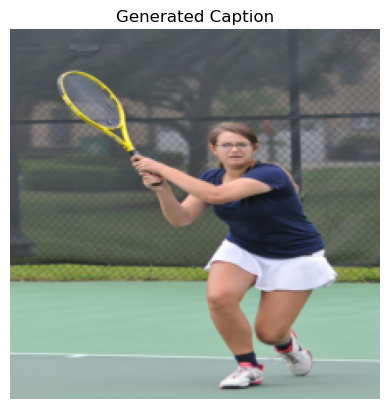

In [46]:
evaluate_bleu(index=6000, val_set=val_set, encoder=encoder, decoder=decoder, vocab=vocab, beam_width=5)